Repeat exercise 15 of Part 2 (text classification with mostly linear classifiers), now using
an MLP classifier implemented (by you) in TensorFlow.

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install --upgrade tensorflow

In [3]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [4]:
!nvidia-smi

Sun Nov 26 17:34:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [5]:
import time
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model


In [6]:
from prettytable import PrettyTable

# Dataset

In [7]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [8]:
def load_train_test_imdb_data(data_dir):
    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    print(data["train"])
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    print(data["test"])
    return data["train"], data["test"]


In [9]:
import os

train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

                                                    text  sentiment
0      Now i really liked this movie, it was so funny...          1
1      I've now watched all four Bo Derek vehicles di...          0
2      Thankfully saw this on a plane to Singapore re...          1
3      ***SPOILERS*** ***SPOILERS*** From its very op...          0
4      It's not a big film. The acting is not amazing...          1
...                                                  ...        ...
24995  Six Degrees is a wonderful show! I watched the...          1
24996  First of all, I have to say I have worked for ...          0
24997  "A Bug's Life" is like a favorite candy bar --...          1
24998  I acquired this, one of my all-time favourite ...          1
24999  I got to see this on the plane to NZ last week...          1

[25000 rows x 2 columns]
                                                    text  sentiment
0      This movie lacked credibility for two reasons....          0
1      Directed by the

In [10]:
train_data

,text,sentiment
0,"Now i really liked this movie, it was so funny...",1
1,I've now watched all four Bo Derek vehicles di...,0
2,Thankfully saw this on a plane to Singapore re...,1
3,***SPOILERS*** ***SPOILERS*** From its very op...,0
4,It's not a big film. The acting is not amazing...,1
...,...,...
24995,Six Degrees is a wonderful show! I watched the...,1
24996,"First of all, I have to say I have worked for ...",0
24997,"""A Bug's Life"" is like a favorite candy bar --...",1
24998,"I acquired this, one of my all-time favourite ...",1


In [11]:
test_data

,text,sentiment
0,This movie lacked credibility for two reasons....,0
1,Directed by the same Jin Ishimoto that put Neo...,0
2,Arising from characters previously developed i...,1
3,If you pack all the clichés about city firefig...,0
4,Prior to Airport 79' these movies were rather ...,0
...,...,...
24995,From the fertile imagination which brought you...,0
24996,"You don't review James Bond movies, you evalua...",1
24997,"The worst film ever, with characters from Carn...",0
24998,This is one of the worst movies I have ever se...,0


In [12]:
df = pd.concat([train_data, test_data], ignore_index=True)
df

,text,sentiment
0,"Now i really liked this movie, it was so funny...",1
1,I've now watched all four Bo Derek vehicles di...,0
2,Thankfully saw this on a plane to Singapore re...,1
3,***SPOILERS*** ***SPOILERS*** From its very op...,0
4,It's not a big film. The acting is not amazing...,1
...,...,...
49995,From the fertile imagination which brought you...,0
49996,"You don't review James Bond movies, you evalua...",1
49997,"The worst film ever, with characters from Carn...",0
49998,This is one of the worst movies I have ever se...,0


In [13]:
x = df['text']
y = df['sentiment']

In [14]:
x

0        Now i really liked this movie, it was so funny...
1        I've now watched all four Bo Derek vehicles di...
2        Thankfully saw this on a plane to Singapore re...
3        ***SPOILERS*** ***SPOILERS*** From its very op...
4        It's not a big film. The acting is not amazing...
                               ...                        
49995    From the fertile imagination which brought you...
49996    You don't review James Bond movies, you evalua...
49997    The worst film ever, with characters from Carn...
49998    This is one of the worst movies I have ever se...
49999    this movie scared the hell out of me for no go...
Name: text, Length: 50000, dtype: object

In [15]:
y

0        1
1        0
2        1
3        0
4        1
        ..
49995    0
49996    1
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

# **Pre-Processing**

In [16]:
import nltk
nltk.download('wordnet')

import re
# Consult python regex docs for Regular Expression usage: https://docs.python.org/3/library/re.html

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
stemmer = WordNetLemmatizer()
docs = []

for doc in x:

    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) #re.I -> ignore case

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    word_list = document.split()

    # Lemmatization
    word_list = [stemmer.lemmatize(word) for word in word_list]

    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(word_list)

    # Append all documents into a list 'docs'
    docs.append(document)

## Average Document Length

In [18]:
# Calculate the total length of documents (in terms of words)
total_words = sum(len(doc.split()) for doc in x)

# Calculate the total number of documents
total_documents = len(docs)

# Calculate the average document length
average_document_length = total_words / total_documents

print(f"Average Document Length: {average_document_length} words")


Average Document Length: 231.15694 words


## Vocabulary

In [19]:
from collections import Counter

# Flatten the list of lists to get a single list of words
all_words = [word for doc in x for word in doc]

# Calculate word frequencies
word_freq = Counter(all_words)

# Set a frequency threshold (adjust as needed)
frequency_threshold = 10

# Filter words based on the threshold
filtered_words = [word for word, freq in word_freq.items() if freq >= frequency_threshold]

# Calculate the vocabulary size (number of unique words after filtering)
vocabulary_size = len(filtered_words)

print(f"The size of the vocabulary, considering words that occur at least 10 times, is: {vocabulary_size}")



The size of the vocabulary, considering words that occur at least 10 times, is: 144


In [20]:
print("\nOriginal review text:\n{}".format(x[0]))
print("\nFiltered review text:\n{}".format(docs[0]))
print("\nLabel:\n", y[0])


Original review text:
Now i really liked this movie, it was so funny.Both Akshay Kumar and John Abraham are brilliant actors, i think after watching this film they should do lots more films together in the future.<br /><br />Akshay Kumar gets himself into a bit of trouble by dating 3 women at the same time, but the way he handles in when one comes out of the door and then the other one was just so funny to watch, he acted really well int his film and i hope that he makes more great comedy's like this one in the future, John Abraham plays his best friend, he plays his role really well and he is so underrated i am glad that some of his amazing work has got noticed but he is a really Good actor. i just love John, Neha Dhupia has a small role in this film and plays it well.<br /><br />The muse is really good i really recommend this movie to everyone.

Filtered review text:
now really liked this movie it wa so funny both akshay kumar and john abraham are brilliant actor think after watchin

# **Split dataset**
In the data preprocessing phase, the dataset was partitioned into training, development, and test sets using the train_test_split function from the scikit-learn library, ensuring a representative distribution of sentiment across the subsets. This systematic division allowed for independent model training on the training set, hyperparameter tuning on the development set, and unbiased evaluation on the test set, fostering a robust analysis of model generalization.

## Training Set

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.3, random_state=23828748)

In [22]:
len(x_train)

35000

## Development Set

In [23]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [24]:
len(x_dev)

5250

In [25]:
# Calculate the number of documents in each set
num_training_documents = len(x_train)
num_dev_documents = len(x_dev)
num_test_documents = len(x_test)

# Print he results
print(f"Number of Training Documents: {num_training_documents}")
print(f"Number of Development Documents: {num_dev_documents}")
print(f"Number of Test Documents: {num_test_documents}")

Number of Training Documents: 29750
Number of Development Documents: 5250
Number of Test Documents: 15000


## Test Set

In [26]:
len(x_test)

15000

## Number of Documents

In [27]:
# Calculate the number of documents in each set
num_training_documents = len(x_train)
num_dev_documents = len(x_dev)
num_test_documents = len(x_test)

# Print he results
print(f"Number of Training Documents: {num_training_documents}")
print(f"Number of Development Documents: {num_dev_documents}")
print(f"Number of Test Documents: {num_test_documents}")

Number of Training Documents: 29750
Number of Development Documents: 5250
Number of Test Documents: 15000


# Tokenization

In [28]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')

def tokenize_text(text):
    doc = nlp(text)  # Tokenize the text into sentences
    tokens = []

    for sent in doc.sents:
        for tok in sent:  # Iterate through the words of the sentence
            # Skip non-useful tokens
            if (
                '\n' in tok.text or
                "\t" in tok.text or
                "--" in tok.text or
                "*" in tok.text or
                tok.text.lower() in STOP_WORDS
            ):
                continue

            if tok.text.strip():
                tokens.append(tok.text.replace('"', "'").strip())

    return tokens

In [29]:
X_train_tokenized = [tokenize_text(text) for text in x_train]
X_dev_tokenized = [tokenize_text(text) for text in x_dev]
X_test_tokenized = [tokenize_text(text) for text in x_test]

In [30]:
for item in X_train_tokenized[:2]:
  print(item, '\n')

['generally', 'fan', 'high', 'school', 'comedy', 'rely', 'heavily', 'humor', 'bad', 'taste', 'rarely', 'stray', 'far', 'clichéd', 'story', 'line', 'character', 'downright', 'dull', 'dialog', 've', 'share', 'guilty', 'pleasure', 'particularly', 'wa', 'high', 'school', 'seeing', 'oh', 'recognizable', 'teacher', 'figure', 'butt', 'kicked', 'cheered', 'occasional', 'laugh', 'case', 'movie', 'work', 'character', 'instantly', 'likable', 'wa', 'case', 'cheat', 'especially', 'protagonist', 'course', 'didn', 'help', 'actor', 'play', 'wa', 'irritating', 'talent', 'arrogant', 'kid', 've', 'seen', 'comedy', 'br', 'br', 'act', 'comedy', 'joke', 'hard', 'funny', 'delivery', 'ha', 'right', 'material', 'waste', 'case', 'wasn', 'good', 'stuff', 'begin', 'joke', 'half', 'funny', 'screwed', 'professionally', 'cast', 'br', 'br', 'movie', 'felt', '3', 'hour', 'long', 'director', 'heard', 'pacing', 'obviously', 'stay', 'away', 'enjoyable', 'teen', 'comedy', '10', 'thing', 'hate', 'daddy', 'superbad'] 

['do

# Training Preparation

## TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigram & bi-gram tf*idf features
# Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_dev_tfidf = vectorizer.transform([" ".join(x) for x in X_dev_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

print(X_train_tfidf.shape)

(29750, 5000)


## SVD

In [32]:
# Reduce dimensionality using svd 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_dev_svd = svd.transform(X_dev_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(X_train_svd.shape)

(29750, 500)


# Evaluation Preparation

In [34]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

# Baseline Models

In [35]:
# Define target names based on your specific class labels
target_names = ["0", "1"]

## Majority Classifier

In [36]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create a majority classifier that always predicts the most frequent class
majority_classifier = DummyClassifier(strategy="most_frequent")
majority_classifier.fit(X_train_svd, y_train)

# Make predictions on the development set
predictions_majority = majority_classifier.predict(X_dev_svd)

# Print the classification report for the majority classifier
print(classification_report(y_dev, predictions_majority, target_names=target_names))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2665
           1       0.49      1.00      0.66      2585

    accuracy                           0.49      5250
   macro avg       0.25      0.50      0.33      5250
weighted avg       0.24      0.49      0.32      5250



In [37]:
from sklearn.metrics import accuracy_score
predictions = majority_classifier.predict(X_dev_svd)
print(f'Validation Accuracy: {accuracy_score(y_dev, predictions)*100:.2f}%')

predictions = majority_classifier.predict(X_test_svd)
print(f'Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Validation Accuracy: 49.24%
Test Accuracy:49.71%


## Logistic Regression - Lasso
The best classifier from exercise 15 of Part 2.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

best_lambda = 1

clf = LogisticRegression(C=1/best_lambda,penalty='l2')
clf.fit(X_train_svd, y_train)

predictions = clf.predict(X_dev_svd)
print(classification_report(y_dev, predictions, target_names=target_names))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2665
           1       0.86      0.88      0.87      2585

    accuracy                           0.87      5250
   macro avg       0.87      0.87      0.87      5250
weighted avg       0.87      0.87      0.87      5250



In [39]:
from sklearn.metrics import accuracy_score
predictions = clf.predict(X_dev_svd)
print(f'Validation Accuracy: {accuracy_score(y_dev, predictions)*100:.2f}%')

predictions = clf.predict(X_test_svd)
print(f'Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Validation Accuracy: 87.22%
Test Accuracy:87.87%


# MLP Classifier

In [40]:
# print("X_train_svd shape:", X_train_svd.shape)
# print("y_train_1_hot shape:", y_train_1_hot.shape)


In [41]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):
    input_dim = X_train_svd.shape[1]

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))


    # Print model summary to verify the architecture
    print(model.summary())

    # Configures the model for training.
    model.compile(
        loss='binary_crossentropy',  # Change to binary_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')

    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(
        'checkpoints/weights.hdf5',
        monitor='val_accuracy',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )

    start_training_time = time.time()
    history = model.fit(
        X_train_svd,
        y_train,
        validation_data=(X_dev_svd, y_dev),
        batch_size=256,
        epochs=100,
        shuffle=True,
        callbacks=[checkpoint]
    )
    end_training_time = time.time()

    print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               64128     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 72449 (283.00 KB)
Trainable params: 72449 (283.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
1

## Visualize History

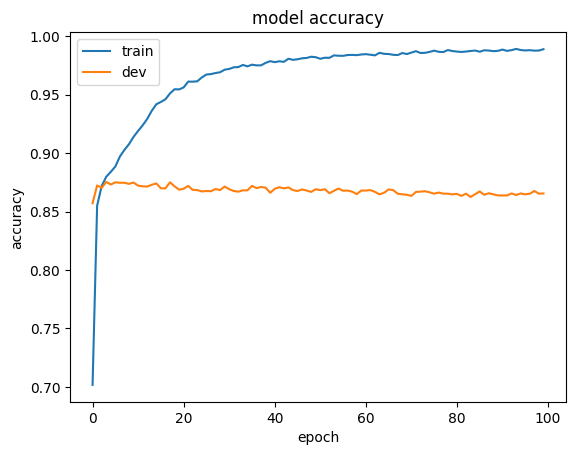

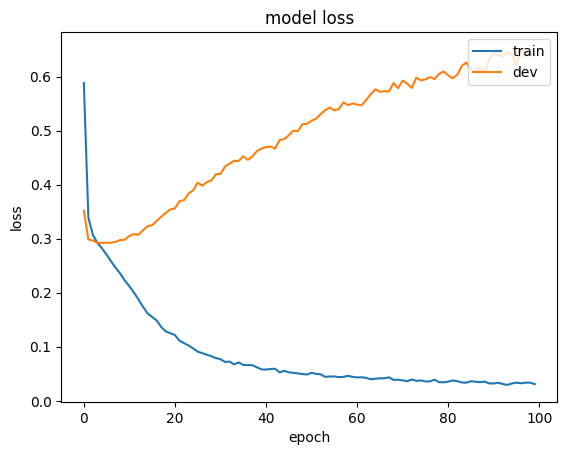

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

As we can see, after 20 epochs, dev loss starts to increase extremely. This fact is an indicator of overfit. That's why we are going to run the model for 20 epochs. \\
However, we also have to tune some hyperparameters too like the number of the hidden layers, the dropout probability and the learning rate too.

In [43]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Load weights from the pre-trained model
    model.load_weights("checkpoints/weights.hdf5")
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=["accuracy"]
        )

    predictions = np.argmax(model.predict(X_dev_svd), -1)
    print(classification_report(y_dev, predictions, target_names=target_names))

165/165 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2665
           1       0.00      0.00      0.00      2585

    accuracy                           0.51      5250
   macro avg       0.25      0.50      0.34      5250
weighted avg       0.26      0.51      0.34      5250



# Hyperparameter Tuning

## Keras Tuner
The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called hyperparameter tuning or hypertuning.
Source: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [44]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.5 MB/s eta 0:00:00


## Number of Layers - Dropout

We started with 3 layers. However, we observed that there are some anomalies in the diagram, so we reduced the layers.


In [45]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# from kerastuner.tuners import RandomSearch
# from tensorflow.keras.regularizers import l1, l2



# # Define the model-building function for Keras Tuner
# def build_model(hp):
#     model = Sequential()
#     # model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu'))
#     model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
#     model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

#     model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
#     model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))

#     model.add(Dense(units=hp.Int('units3', min_value=32, max_value=256, step=32), activation='relu'))
#     model.add(Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.5, step=0.1)))


#     # You can add more layers and dropout rates as needed

#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(
#         loss='binary_crossentropy',
#         optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1, sampling='log')),
#         # optimizer=Adam(learning_rate=0.0001)
#         metrics=["accuracy"]
#     )

#     return model

# # Set up the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  # You can increase this number for a more exhaustive search
#     directory='keras_tuner_dir',
#     project_name='my_first_tuning_experiment'
# )

# # Perform the hyperparameter search
# tuner.search(
#     X_train_svd,
#     y_train,
#     validation_data=(X_dev_svd, y_dev),
#     epochs=100,
#     batch_size=256
# )

# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hp)

# # Train the model with the best hyperparameters
# history = best_model.fit(
#     X_train_svd,
#     y_train,
#     validation_data=(X_dev_svd, y_dev),
#     epochs=100,
#     batch_size=256
# )

# # Print the summary of the best model
# print(best_model.summary())

# # Save the best model
# best_model.save('first_model.h5')


In [46]:
# # Print the best hyperparameters
# print("Best Hyperparameters:")
# print(f" - Units in the first hidden layer: {best_hp.get('units1')}")
# print(f" - Dropout rate in the first hidden layer: {best_hp.get('dropout1')}")
# print(f" - Units in the second hidden layer: {best_hp.get('units2')}")
# print(f" - Dropout rate in the second hidden layer: {best_hp.get('dropout2')}")
# print(f" - Learning rate: {best_hp.get('learning_rate')}")

In [47]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper right')
# plt.show()

We noticed oscillations in the curves beyond 2 layers. Consequently, we decided to stick with 2 layers. Regarding Dropout probability, we tested various values and selected the most effective for each layer.

## Regularization

We opted to incorporate regularization techniques, such as dropout and L2 regularization, in our Multilayer Perceptron (MLP) model to address the potential risk of overfitting. Regularization helps prevent the network from becoming too specialized to the training data, promoting better generalization to new, unseen samples.

In [48]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l1, l2



# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu'))
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))


    # You can add more layers and dropout rates as needed

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1, sampling='log')),
        # optimizer=Adam(learning_rate=0.0001)
        metrics=["accuracy"]
    )

    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can increase this number for a more exhaustive search
    directory='keras_tuner_dir',
    project_name='my_tuning_experiment'
)

# Perform the hyperparameter search
tuner.search(
    X_train_svd,
    y_train,
    validation_data=(X_dev_svd, y_dev),
    epochs=100,
    batch_size=256
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train_svd,
    y_train,
    validation_data=(X_dev_svd, y_dev),
    epochs=100,
    batch_size=256
)

# Print the summary of the best model
print(best_model.summary())

# Save the best model
best_model.save('best_model.h5')


Trial 5 Complete [00h 01m 24s]
val_accuracy: 0.8788571357727051

Best val_accuracy So Far: 0.8788571357727051
Total elapsed time: 00h 06m 17s
Epoch 1/100
117/117 [==============================] - 2s 6ms/step - loss: 3.3702 - accuracy: 0.6021 - val_loss: 2.1229 - val_accuracy: 0.7501
Epoch 2/100
117/117 [==============================] - 1s 4ms/step - loss: 1.4863 - accuracy: 0.7713 - val_loss: 0.9981 - val_accuracy: 0.8398
Epoch 3/100
117/117 [==============================] - 1s 4ms/step - loss: 0.7586 - accuracy: 0.8374 - val_loss: 0.5765 - val_accuracy: 0.8653
Epoch 4/100
117/117 [==============================] - 1s 4ms/step - loss: 0.5116 - accuracy: 0.8532 - val_loss: 0.4460 - val_accuracy: 0.8695
Epoch 5/100
117/117 [==============================] - 1s 4ms/step - loss: 0.4353 - accuracy: 0.8610 - val_loss: 0.4034 - val_accuracy: 0.8680
Epoch 6/100
117/117 [==============================] - 1s 4ms/step - loss: 0.4055 - accuracy: 0.8636 - val_loss: 0.3830 - val_accuracy: 0.8710


In [49]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - Units in the first hidden layer: {best_hp.get('units1')}")
print(f" - Dropout rate in the first hidden layer: {best_hp.get('dropout1')}")
print(f" - Units in the second hidden layer: {best_hp.get('units2')}")
print(f" - Dropout rate in the second hidden layer: {best_hp.get('dropout2')}")
print(f" - Learning rate: {best_hp.get('learning_rate')}")

Best Hyperparameters:
 - Units in the first hidden layer: 384
 - Dropout rate in the first hidden layer: 0.30000000000000004
 - Units in the second hidden layer: 32
 - Dropout rate in the second hidden layer: 0.4
 - Learning rate: 0.0002396651175750416


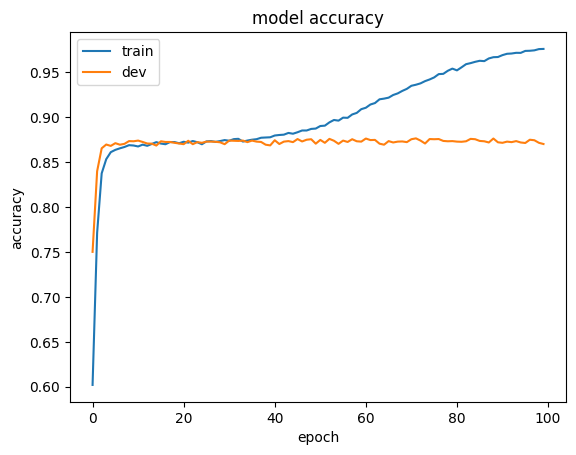

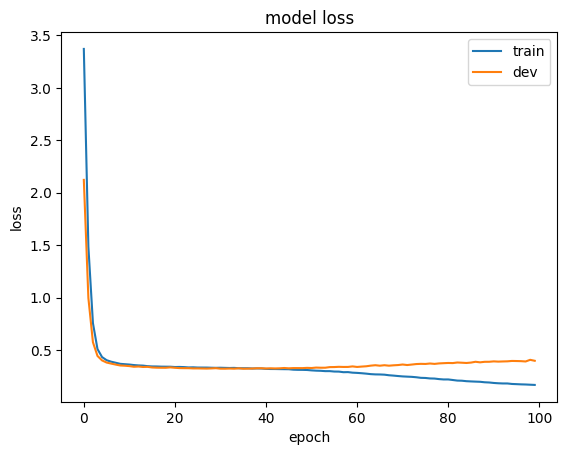

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

## Number of Epochs

As evident from the loss curves depicted above, the development loss experiences an increase after 60 epochs. Consequently, we made the decision to conclude the training process at this point.

In [51]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l1, l2

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu'))
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1, sampling='log')),
        # optimizer=Adam(learning_rate=0.0001)
        metrics=["accuracy"]
    )

    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can increase this number for a more exhaustive search
    directory='keras_tuner_dir',
    project_name='my_tuning_experiment'
)

tuner.search(
    X_train_svd,
    y_train,
    validation_data=(X_dev_svd, y_dev),
    epochs=100,
    batch_size=256
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train_svd,
    y_train,
    validation_data=(X_dev_svd, y_dev),
    epochs=70,
    batch_size=256
)

# Print the summary of the best model
print(best_model.summary())

# Save the best model
best_model.save('best_stopping_model.h5')


Reloading Tuner from keras_tuner_dir/my_tuning_experiment/tuner0.json
Epoch 1/70
117/117 [==============================] - 2s 6ms/step - loss: 3.3844 - accuracy: 0.6188 - val_loss: 2.1285 - val_accuracy: 0.8046
Epoch 2/70
117/117 [==============================] - 1s 4ms/step - loss: 1.4829 - accuracy: 0.7893 - val_loss: 0.9861 - val_accuracy: 0.8530
Epoch 3/70
117/117 [==============================] - 1s 5ms/step - loss: 0.7488 - accuracy: 0.8394 - val_loss: 0.5687 - val_accuracy: 0.8655
Epoch 4/70
117/117 [==============================] - 1s 4ms/step - loss: 0.5032 - accuracy: 0.8562 - val_loss: 0.4405 - val_accuracy: 0.8695
Epoch 5/70
117/117 [==============================] - 1s 6ms/step - loss: 0.4285 - accuracy: 0.8627 - val_loss: 0.3991 - val_accuracy: 0.8699
Epoch 6/70
117/117 [==============================] - 1s 8ms/step - loss: 0.4015 - accuracy: 0.8647 - val_loss: 0.3804 - val_accuracy: 0.8705
Epoch 7/70
117/117 [==============================] - 1s 11ms/step - loss: 0.3

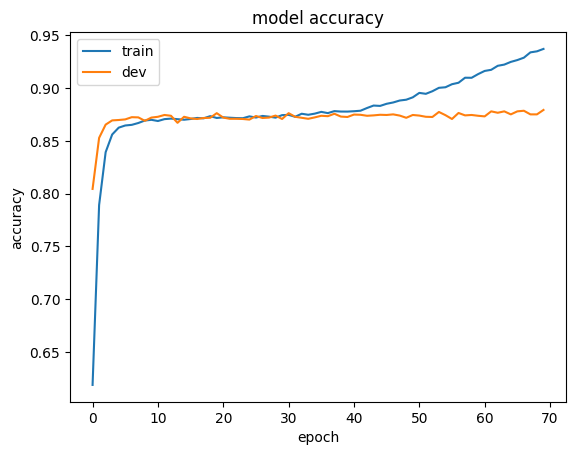

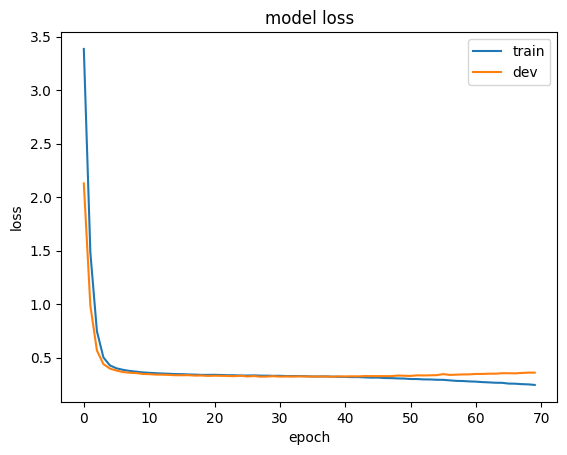

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

## Performance

In [53]:
test_loss, test_accuracy = best_model.evaluate(X_test_svd, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

469/469 [==============================] - 2s 3ms/step - loss: 0.3526 - accuracy: 0.8810
Test Loss: 0.3526, Test Accuracy: 0.8810


In [54]:
from sklearn.metrics import accuracy_score

dev_predictions = (best_model.predict(X_dev_svd) >= 0.5).astype(int)
test_predictions = (best_model.predict(X_test_svd) >= 0.5).astype(int)

dev_accuracy = accuracy_score(y_dev, dev_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f'Development Accuracy: {dev_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

469/469 [==============================] - 1s 2ms/step
Development Accuracy: 87.94%
Test Accuracy: 88.10%


# Metrics

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve
import matplotlib.pyplot as plt

classifiers = [majority_classifier, clf, best_model]
classifier_names = ["Majority Classifier", "Logistic Regression - Lasso", "Best Model"]

In [56]:
classes = [0,1]

## Precision - Recall - F1 - AUC

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

tables = []

# Loop through each classifier
for classifier, classifier_name in zip(classifiers, classifier_names):
    # Initialize empty DataFrames for training, development, and test
    train_table = pd.DataFrame(columns=['Class', 'Precision', 'Recall', 'F1', 'PR-AUC'])
    dev_table = pd.DataFrame(columns=['Class', 'Precision', 'Recall', 'F1', 'PR-AUC'])
    test_table = pd.DataFrame(columns=['Class', 'Precision', 'Recall', 'F1', 'PR-AUC'])

    # Loop through each class
    for class_name in classes:
        # Initialize an empty list to store metrics for the current class
        metrics_train = []
        metrics_dev = []
        metrics_test = []


        for subset_name, y_true, X in [('Training', y_train, X_train_svd),
                                       ('Development', y_dev, X_dev_svd),
                                       ('Test', y_test, X_test_svd)]:
            # Filter data for the current class
            y_true_class = (y_true == class_name)

            if hasattr(classifier, 'predict_proba'):
                y_pred_prob = classifier.predict_proba(X)[:, 1]
                y_pred_class = (y_pred_prob >= 0.5).astype(int)
            else:  # For classifiers without predict_proba (like MLP)
                y_pred_prob = classifier.predict(X).ravel()
                y_pred_class = (y_pred_prob >= 0.5).astype(int)

            precision = precision_score(y_true_class, y_pred_class)
            recall = recall_score(y_true_class, y_pred_class)
            f1 = f1_score(y_true_class, y_pred_class)
            pr_auc = average_precision_score(y_true_class, y_pred_prob)


            if subset_name == 'Training':
                metrics_train.extend([class_name, precision, recall, f1, pr_auc])
            elif subset_name == 'Development':
                metrics_dev.extend([class_name, precision, recall, f1, pr_auc])
            elif subset_name == 'Test':
                metrics_test.extend([class_name, precision, recall, f1, pr_auc])

        train_table = train_table.append(pd.Series(metrics_train, index=train_table.columns), ignore_index=True)
        dev_table = dev_table.append(pd.Series(metrics_dev, index=dev_table.columns), ignore_index=True)
        test_table = test_table.append(pd.Series(metrics_test, index=test_table.columns), ignore_index=True)

    tables.append((f"Classifier: {classifier_name}", train_table, dev_table, test_table))


for table_str, train_df, dev_df, test_df in tables:
    print(table_str)
    print("Training Table:")
    print(train_df)
    print("\nDevelopment Table:")
    print(dev_df)
    print("\nTest Table:")
    print(test_df)
    print("\n")

469/469 [==============================] - 1s 2ms/step
Classifier: Majority Classifier
Training Table:
   Class  Precision  Recall        F1   PR-AUC
0    0.0    0.49721     1.0  0.664182  0.49721
1    1.0    0.50279     1.0  0.669142  0.50279

Development Table:
   Class  Precision  Recall        F1    PR-AUC
0    0.0   0.507619     1.0  0.673405  0.507619
1    1.0   0.492381     1.0  0.659860  0.492381

Test Table:
   Class  Precision  Recall        F1    PR-AUC
0    0.0   0.502867     1.0  0.669210  0.502867
1    1.0   0.497133     1.0  0.664114  0.497133


Classifier: Logistic Regression - Lasso
Training Table:
   Class  Precision    Recall        F1    PR-AUC
0    0.0   0.124609  0.129124  0.126826  0.308679
1    1.0   0.875391  0.897045  0.886086  0.952225

Development Table:
   Class  Precision    Recall        F1    PR-AUC
0    0.0   0.138868  0.138086  0.138476  0.317614
1    1.0   0.861132  0.882785  0.871824  0.944141

Test Table:
   Class  Precision    Recall        F1    P

## Macro - Metrics

In [58]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

tables = []


for classifier, classifier_name in zip(classifiers, classifier_names):
    # Initialize lists to store macro-averaged scores
    macro_precision_train = []
    macro_recall_train = []
    macro_f1_train = []
    macro_pr_auc_train = []

    macro_precision_dev = []
    macro_recall_dev = []
    macro_f1_dev = []
    macro_pr_auc_dev = []

    macro_precision_test = []
    macro_recall_test = []
    macro_f1_test = []
    macro_pr_auc_test = []


    columns = ['Class', 'Precision (Train)', 'Recall (Train)', 'F1 (Train)', 'PR-AUC (Train)',
               'Precision (Dev)', 'Recall (Dev)', 'F1 (Dev)', 'PR-AUC (Dev)',
               'Precision (Test)', 'Recall (Test)', 'F1 (Test)', 'PR-AUC (Test)']

    df = pd.DataFrame(columns=columns)


    for class_name in classes:
        # Initialize an empty list to store metrics for the current class
        metrics_train = []
        metrics_dev = []
        metrics_test = []


        for subset_name, y_true, X in [('Training', y_train, X_train_svd),
                                       ('Development', y_dev, X_dev_svd),
                                       ('Test', y_test, X_test_svd)]:

            y_true_class = (y_true == class_name)

            if hasattr(classifier, 'predict_proba'):
                y_pred_prob = classifier.predict_proba(X)[:, 1]
                y_pred_class = (y_pred_prob >= 0.5).astype(int)
            else:
                y_pred_prob = classifier.predict(X).ravel()
                y_pred_class = (y_pred_prob >= 0.5).astype(int)

            precision = precision_score(y_true_class, y_pred_class)
            recall = recall_score(y_true_class, y_pred_class)
            f1 = f1_score(y_true_class, y_pred_class)
            pr_auc = average_precision_score(y_true_class, y_pred_prob)

            if subset_name == 'Training':
                metrics_train.extend([precision, recall, f1, pr_auc])
            elif subset_name == 'Development':
                metrics_dev.extend([precision, recall, f1, pr_auc])
            elif subset_name == 'Test':
                metrics_test.extend([precision, recall, f1, pr_auc])

        # Append the scores for macro-averaging
        macro_precision_train.append(metrics_train[0])
        macro_recall_train.append(metrics_train[1])
        macro_f1_train.append(metrics_train[2])
        macro_pr_auc_train.append(metrics_train[3])

        macro_precision_dev.append(metrics_dev[0])
        macro_recall_dev.append(metrics_dev[1])
        macro_f1_dev.append(metrics_dev[2])
        macro_pr_auc_dev.append(metrics_dev[3])

        macro_precision_test.append(metrics_test[0])
        macro_recall_test.append(metrics_test[1])
        macro_f1_test.append(metrics_test[2])
        macro_pr_auc_test.append(metrics_test[3])

        # Append the row to the DataFrame
        df = df.append(pd.Series([class_name] + metrics_train + metrics_dev + metrics_test, index=columns), ignore_index=True)

    # Calculate macro-averaged scores for all subsets
    macro_precision_avg_train = sum(macro_precision_train) / len(classes)
    macro_recall_avg_train = sum(macro_recall_train) / len(classes)
    macro_f1_avg_train = sum(macro_f1_train) / len(classes)
    macro_pr_auc_avg_train = sum(macro_pr_auc_train) / len(classes)

    macro_precision_avg_dev = sum(macro_precision_dev) / len(classes)
    macro_recall_avg_dev = sum(macro_recall_dev) / len(classes)
    macro_f1_avg_dev = sum(macro_f1_dev) / len(classes)
    macro_pr_auc_avg_dev = sum(macro_pr_auc_dev) / len(classes)

    macro_precision_avg_test = sum(macro_precision_test) / len(classes)
    macro_recall_avg_test = sum(macro_recall_test) / len(classes)
    macro_f1_avg_test = sum(macro_f1_test) / len(classes)
    macro_pr_auc_avg_test = sum(macro_pr_auc_test) / len(classes)


    tables.append((f"Classifier: {classifier_name}", df,
                   [macro_precision_avg_train, macro_recall_avg_train, macro_f1_avg_train, macro_pr_auc_avg_train],
                   [macro_precision_avg_dev, macro_recall_avg_dev, macro_f1_avg_dev, macro_pr_auc_avg_dev],
                   [macro_precision_avg_test, macro_recall_avg_test, macro_f1_avg_test, macro_pr_auc_avg_test]))


for classifier_name, df, macro_avg_train, macro_avg_dev, macro_avg_test in tables:
    print(f"\nClassifier: {classifier_name}")
    print("Individual Metrics:")
    print(df.to_string(index=False))
    print("\nMacro-Averaged Metrics:")
    print(pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1', 'PR-AUC'],
                        'Macro Avg (Train)': macro_avg_train,
                        'Macro Avg (Dev)': macro_avg_dev,
                        'Macro Avg (Test)': macro_avg_test}).to_string(index=False))


469/469 [==============================] - 1s 2ms/step

Classifier: Classifier: Majority Classifier
Individual Metrics:
 Class  Precision (Train)  Recall (Train)  F1 (Train)  PR-AUC (Train)  Precision (Dev)  Recall (Dev)  F1 (Dev)  PR-AUC (Dev)  Precision (Test)  Recall (Test)  F1 (Test)  PR-AUC (Test)
   0.0            0.49721             1.0    0.664182         0.49721         0.507619           1.0  0.673405      0.507619          0.502867            1.0   0.669210       0.502867
   1.0            0.50279             1.0    0.669142         0.50279         0.492381           1.0  0.659860      0.492381          0.497133            1.0   0.664114       0.497133

Macro-Averaged Metrics:
   Metric  Macro Avg (Train)  Macro Avg (Dev)  Macro Avg (Test)
Precision           0.500000         0.500000          0.500000
   Recall           1.000000         1.000000          1.000000
       F1           0.666662         0.666632          0.666662
   PR-AUC           0.500000         0.500000  

# Performance Comparison Across Models

|Model Name|Val Accuracy|Test Accuracy|
|----------|--------|--|
|Majority Classifier + TF-IDF|49.24%|49.71% |
|Logistic Regression + TF-IDF + L1|87.22%|87.87% |
|MLP + TF-IDF + L1|87.94%|       88.10%    |
